# 巡回セールスマン問題

$$
\begin{aligned}
\min_x & \sum_{i,j}d_{i,j}x_{i,t} x_{j,(t+1)\mod n}\\
\mathrm{s.t.} &\sum_t x_{i,t}=1, \forall i\\
&\sum_i x_{i,t} = 1,~\forall t\\
&x_{i,t} \in \{0, 1\}
\end{aligned}
$$

In [1]:
import numpy as np

# ランダムに都市を配置して距離行列を計算
def tsp_distance(n: int):
    x = np.random.uniform(0, 1, n)
    y = np.random.uniform(0, 1, n)
    XX, YY = np.meshgrid(x, y)
    distance = np.sqrt((XX - XX.T)**2 + (YY - YY.T)**2)
    return distance, (x, y)

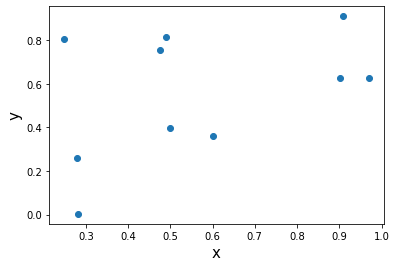

In [2]:
import matplotlib.pyplot as plt

# n-都市 平面TSP
n = 10

distance, (x_pos, y_pos) = tsp_distance(n=n)

plt.plot(x_pos, y_pos, 'o')
plt.xlabel("x", fontsize=15)
plt.ylabel("y", fontsize=15)
plt.show()

## JijModelingによる実装

In [3]:
import jijmodeling as jm

n = jm.Placeholder("n")
d = jm.Placeholder("d", shape=(n, n))

x = jm.Binary("x", shape=(n, n))

i = jm.Element("i", (0, n))
j = jm.Element("j", (0, n))
t = jm.Element("t", (0, n))

In [4]:
# problem object の作成
problem = jm.Problem("tsp")

# 目的関数の追加
problem += jm.Sum([i, j, t], d[i, j]*x[i, t]*x[j, (t+1) % n])
# 等価な書き方
# problem += jm.Sum(i, jm.Sum(j, jm.Sum(t, d[i, j]*x[i, t]*x[j, (t+1) % n])))

# 2つの制約条件の追加
problem += jm.Constraint("one-city", jm.Sum(t, x[i, t]) == 1, forall=i)
problem += jm.Constraint("one-time", jm.Sum(i, x[i, t]) == 1, forall=t)
problem

In [5]:
instance_data = {
    "d": distance,
    "n": len(distance)
}
multipliers = {"one-city": 1.0, "one-time": 1.0}

In [6]:
import jijzept as jz

sampler = jz.JijSASampler(config="config.toml")
response = sampler.sample_model(problem, instance_data, multipliers, num_reads=20)

decoded = problem.decode(response, instance_data)
decoded

uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is 3cd02b180e994f50b9d7c6a2dfa537dc.


DecodedSamples(feasibles = 7[/20], objective = 1.9598380150447348, energy = -7.385749197202959)

In [7]:
# 結果となるバイナリの値を取得する
x_value = decoded.solutions[0]['x']
print(x_value)

# 制約条件が満たされているかを確認する
print(decoded.constraint_violations[0])

# forallごとの詳細の値を確認する
print(decoded.constraint_expr_value[0])

#　目的関数値
print("Objective: ", decoded.objectives[0])

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
{'one-city': 1.0, 'one-time': 1.0}
{'one-city': {(0,): 0.0, (1,): 0.0, (2,): 0.0, (3,): 0.0, (4,): 0.0, (5,): 0.0, (6,): 0.0, (7,): 0.0, (8,): -1.0, (9,): 0.0}, 'one-time': {(0,): 0.0, (1,): 0.0, (2,): -1.0, (3,): 0.0, (4,): 0.0, (5,): 0.0, (6,): 0.0, (7,): 0.0, (8,): 0.0, (9,): 0.0}}
Objective:  2.2865543049217933


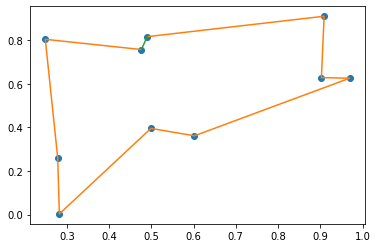

In [8]:
import numpy as np

feasibles = decoded.feasibles()
argmin_e = np.argmin(feasibles.objective)
tour = np.where(feasibles[argmin_e].solution['x'].T == 1)[1]
plt.plot(x_pos, y_pos, "o")
plt.plot(x_pos[tour], y_pos[tour], "-")
plt.plot(x_pos[[tour[-1], tour[0]]], y_pos[[tour[-1], tour[0]]], "-")